# CNN With Resnet18

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time
import copy
import glob

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

The data we are using in this part of project are 10 classes of dogs selected from the whole 120 classes of dogs, we are doing that because it will greatly reduce the run time for this algorithm. The final result we get from this algorithm might be different compare to using all the images, but the difference expected should be small.

the following two cells will splite the 10 classes of datasets into 80% train, 10% val and 10% test sets. It will generate a new classes ipny.checkpoints in each train val and test folder so remember to delete it.

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("./image10_modified", output="output_modified",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

read the image data after normalization.

In [3]:
data_path = './output_modified/train'
transform = transforms.Compose(
                [
#                     transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                ])
train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

print(len(train_loader))

24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])
tensor(7)


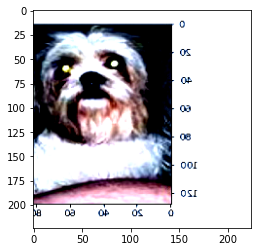

In [6]:
batch = next(iter(train_loader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [7]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
resnet18.fc = nn.Linear(512, 10)

In [10]:
##for name, param in resnet18.named_parameters():
    ##if param.requires_grad:
        ##print(name, param.data)

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_train=True):
    since = time.time()
    
    acc_history = []
    loss_history = []

    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), os.path.join('./working', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history, loss_history

In [12]:
# Here we only want to update the gradient for the classifier layer that we initialized.
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Train model
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/24
----------


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 1.2259 Acc: 0.5898

Epoch 1/24
----------
Loss: 0.9095 Acc: 0.6904

Epoch 2/24
----------
Loss: 0.8677 Acc: 0.7061

Epoch 3/24
----------
Loss: 0.7576 Acc: 0.7459

Epoch 4/24
----------
Loss: 0.7222 Acc: 0.7583

Epoch 5/24
----------
Loss: 0.6838 Acc: 0.7629

Epoch 6/24
----------
Loss: 0.7099 Acc: 0.7596

Epoch 7/24
----------
Loss: 0.6379 Acc: 0.7838

Epoch 8/24
----------
Loss: 0.6373 Acc: 0.7864

Epoch 9/24
----------
Loss: 0.5836 Acc: 0.7995

Epoch 10/24
----------
Loss: 0.5094 Acc: 0.8191

Epoch 11/24
----------
Loss: 0.5347 Acc: 0.8295

Epoch 12/24
----------
Loss: 0.5784 Acc: 0.7982

Epoch 13/24
----------
Loss: 0.5133 Acc: 0.8171

Epoch 14/24
----------
Loss: 0.5431 Acc: 0.8178

Epoch 15/24
----------
Loss: 0.4991 Acc: 0.8374

Epoch 16/24
----------
Loss: 0.4938 Acc: 0.8374

Epoch 17/24
----------
Loss: 0.4963 Acc: 0.8289

Epoch 18/24
----------
Loss: 0.4557 Acc: 0.8485

Epoch 19/24
----------
Loss: 0.4766 Acc: 0.8485

Epoch 20/24
----------
Loss: 0.4528 Acc: 0.8426

Epo

In [14]:
test_path = './output_modified/test'
transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=False
)

print(len(test_loader))

4


In [15]:
def eval_model(model, dataloaders, device):
    since = time.time()
    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./working/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [16]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./working/00.pth', './working/01.pth', './working/02.pth', './working/03.pth', './working/04.pth', './working/05.pth', './working/06.pth', './working/07.pth', './working/08.pth', './working/09.pth', './working/10.pth', './working/11.pth', './working/12.pth', './working/13.pth', './working/14.pth', './working/15.pth', './working/16.pth', './working/17.pth', './working/18.pth', './working/19.pth', './working/20.pth', './working/21.pth', './working/22.pth', './working/23.pth', './working/24.pth']
Loading model ./working/00.pth
Acc: 0.6617

Loading model ./working/01.pth
Acc: 0.5025

Loading model ./working/02.pth
Acc: 0.7114

Loading model ./working/03.pth
Acc: 0.6617

Loading model ./working/04.pth
Acc: 0.6965

Loading model ./working/05.pth
Acc: 0.7065

Loading model ./working/06.pth
Acc: 0.6766

Loading model ./working/07.pth
Acc: 0.7164

Loading model ./working/08.pth
Acc: 0.7463

Loading model ./working/09.pth
Acc: 0.7214

Loading model ./working/10.pth
Acc: 0.8209

Loa

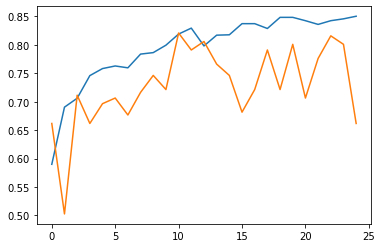

In [17]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

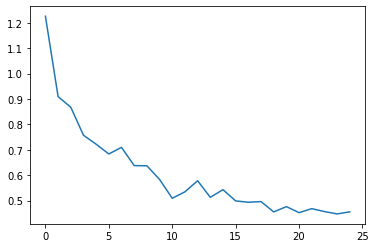

In [18]:
plt.plot(train_loss_hist)
plt.show()